In [1]:
import requests
from rdflib import Graph
from rdflib.namespace import Namespace, OWL, RDF, RDFS

from ir_onto_demos_utilities import (
    show_instances, show_owl_classes, show_owl_obj_props, 
    sparql_update, sparql_select, insert_graph, delete_graph,
    show_graph_portion
)

TODOs:
- Group the searches demo process into on function
- Demo a search refinement process
- Demo adding some transversal relations
- Demo studying some incompatible searches and documents.

# Demo: Information Retrieval ontology

Requirements:

- Docker must be installed and running (See Docker website for installation details: <https://docs.docker.com/get-started/overview/>).
- We use docker to run the Ontotext GraphDB triple store: <https://www.ontotext.com/products/graphdb/>. Hence is it best if the docker image is already downloaded. Once you have docker installed and running you can run in a terminal the following command: `docker pull ontotext/graphdb:10.4.0`.
- We use Python 3.10. For the python dependencies you can run `pip install -r requirements.txt` from the project root.

## Introduction

The main goal of this demo is to demonstrate the power of the Information Retrieval ontology. In a subsequent demo, we will demonstrate how one can leverage the same data graph for a separate purpose by simply applying another domain graph, i.e., another point of view on the same data.

For our purpose we define a Knowledge Graph by deriving an RDF-based representation inspired from our understanding of the book "Knowledge Graphs" (<https://kgbook.org/>). Hence, the KG we will construct is based on the Directed Edge Labelled Graph (DELG) model (implemented using the Resource Description Framework (RDF)). As defined in the mentioned book we distinguish between the data graph and the domain graph, and even the mapping graph. The data graph represent the data. The domain graph represent the knowledge. And there exists a mapping between the both graph that we also represent as a graph. The following figure summarise our definition of a KG derived from the book.

<!-- ![KG definition](data/kg_def_sw_technos.png "Title") -->
<img src="data/kg_def_sw_technos.png" alt="KG definition" width="1000" align="middle"/>

Round boxes denote components, while squared ones denote processes. Bold names in round boxes are the main components' labels. Some alternative labels are added below and in parentheses. The boxes' imbrications denote composition relations. The round box labelled __Mapping__ straddles the __Domain graph__ and __Data graph__ boxes denoting its mapping role. Finally, some SW candidate technologies to implement each component are mentioned in blue bold italic and underlined letters.

In this demo we focus on:

- Clearly distinguishing between the domain, mapping, and data graphs
- Constructing a custom domain graph by extending an existing upper ontology, e.g., the Information Retrieval ontology
- Leveraging SPARQL construct queries to build a mapping graph
- Demonstrating how one can leverage the IR ontology logic to:
  - Running a DL-based facetted search
  - Analyse user queries and find semantically inconsistent ones
  - Spotting some inconsistent documents

## Context

To demonstrate the potential of the IR ontology, we put it into practice following an example around pizzas. Some might notice that this example is chosen on purpose. Indeed, we will leverage the famous pizza ontology and the multiple existing variants.

Let us introduce the context by putting ourselves in the choose of Roger, a pizza and technology lover. We have been making pizzas for as long as we can remember and now have our own restaurant. The business if going well and we decide to wisely allocate some time and money to leverage as best as possible our knowledge acquired by long years of experience. We recently heard about this fascinating technology that are KGs. Their representation of Semantics enables machines to look even smarter than before. So we decide to make a KG of our pizzas. In practice we first implement a data graph.

## The data graph

Our data graph is composed of two parts. The first is representing the pizzas proposed in our menu. For the purpose of this example we will use the pizzas proposed on the menu of the Bisou, a great pizzeria located in Rouen, France. You can find the menu here: <https://www.bisourouen.fr/#la-carte> (Accessed on December 2023). The second part focuses on different taxonomies we use to organise our pizzas.

### The pizza graph

To represent our pizzas we use the following relations:

- `has_topping` links a pizza to an a topping ingredient.
- `has_kind` links a pizza to an a sort of pizza, e.g., vegetarian.
- `has_base` links a pizza to an a its base.
- `has_spiciness` links a pizza to a spiciness level.

According to the menu, we have 12 pizzas in our data graph, namely, ...

In [2]:
# define some namespaces
pizza_ns = Namespace("http://www.msesboue.org/o/pizza-data-demo/bisou#")
ir_onto_ns = Namespace("http://www.msesboue.org/o/ir-ontology#")

In [3]:
# Load the pizza data graph
pizza_bisou_g = Graph()
pizza_bisou_g.bind(prefix="pizza", namespace=pizza_ns)
pizza_bisou_g.parse("./data/pizzas_bisou.ttl")

<Graph identifier=Ncf6d82995a994411a8ed3e025437940a (<class 'rdflib.graph.Graph'>)>

In [4]:
# Query for the distinct relations in the data graph
q_relations = """
    SELECT DISTINCT ?rel WHERE {
        ?s ?rel ?o .
    }
"""

for r in pizza_bisou_g.query(q_relations):
    print(r["rel"])

http://www.msesboue.org/o/pizza-data-demo/bisou#has_kind
http://www.msesboue.org/o/pizza-data-demo/bisou#has_topping
http://www.msesboue.org/o/pizza-data-demo/bisou#has_base
http://www.msesboue.org/o/pizza-data-demo/bisou#has_spiciness


In [5]:
# Query for the pizzas in the data graph
q_relations = """
    SELECT DISTINCT ?pizza WHERE {
        ?pizza pizza:has_base ?base .
    }
"""

for r in pizza_bisou_g.query(q_relations):
    print(r["pizza"])

http://www.msesboue.org/o/pizza-data-demo/bisou#_bambino
http://www.msesboue.org/o/pizza-data-demo/bisou#_burraTadah
http://www.msesboue.org/o/pizza-data-demo/bisou#_godSaveTheKing
http://www.msesboue.org/o/pizza-data-demo/bisou#_margherita20
http://www.msesboue.org/o/pizza-data-demo/bisou#_biancaCastafiore
http://www.msesboue.org/o/pizza-data-demo/bisou#_mortadella
http://www.msesboue.org/o/pizza-data-demo/bisou#_hotStuff40
http://www.msesboue.org/o/pizza-data-demo/bisou#_laVieEnRose
http://www.msesboue.org/o/pizza-data-demo/bisou#_leonardo
http://www.msesboue.org/o/pizza-data-demo/bisou#_quatroFromaggi
http://www.msesboue.org/o/pizza-data-demo/bisou#_tartufo
http://www.msesboue.org/o/pizza-data-demo/bisou#_zucchero


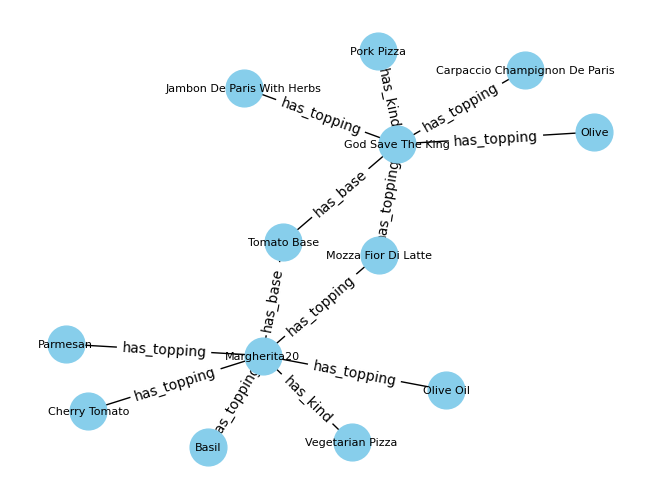

In [6]:
# Let us visualise some of our pizza data graph
show_graph_portion(subject_uris={pizza_ns._godSaveTheKing, pizza_ns._margherita20}, graph=pizza_bisou_g)

### Taxonomies data graph

In our taxonomy data graph, we represent four taxonomies:
- A taxonomy of pizza bases
- A taxonomy of pizza kinds
- A taxonomy of pizza toppings
- A taxonomy of spiciness

The categories in the taxonomy data graph are linked together by "has subcategory" relations.

In [7]:
# Load the taxonomies data graph
taxonomies_g = Graph()
taxonomies_g.bind(prefix="pizza", namespace=pizza_ns)
taxonomies_g.parse("./data/pizzas_bisou_taxo.ttl")

<Graph identifier=N0b028180e2fc4f8faf2138787e5bd3d5 (<class 'rdflib.graph.Graph'>)>

In [8]:
# Let us find the top categories in our taxonomies
# A top category is a node in our data graph which do not have an in coming "has subcategory" link

q_top_categories = """
    SELECT DISTINCT ?top_cate WHERE {
        ?top_cate  pizza:has_subcategory  ?subcate .
        FILTER NOT EXISTS {
            ?other_cate  pizza:has_subcategory  ?top_cate .
        }
    }
"""
for r in taxonomies_g.query(q_top_categories): # This query is made over the ingredient graph
    print(r["top_cate"]) # print the pizzas URI

http://www.msesboue.org/o/pizza-data-demo/bisou#_pizzaBase
http://www.msesboue.org/o/pizza-data-demo/bisou#_pizzaKind
http://www.msesboue.org/o/pizza-data-demo/bisou#_pizzaSpiciness
http://www.msesboue.org/o/pizza-data-demo/bisou#_pizzaTopping


In [9]:
# Let us look at the triples in the pizza base taxonomy

q_pizza_bases = """
    SELECT ?cate WHERE {
        pizza:_pizzaBase  pizza:has_subcategory*  ?cate .
    }
"""
for r in taxonomies_g.query(q_pizza_bases): # This query is made over the taxonomies graph
    print(r["cate"]) # print the category URI

http://www.msesboue.org/o/pizza-data-demo/bisou#_pizzaBase
http://www.msesboue.org/o/pizza-data-demo/bisou#_creamBase
http://www.msesboue.org/o/pizza-data-demo/bisou#_blackTruffleCreamBase
http://www.msesboue.org/o/pizza-data-demo/bisou#_mustardCreamBase
http://www.msesboue.org/o/pizza-data-demo/bisou#_oignonCreamBase
http://www.msesboue.org/o/pizza-data-demo/bisou#_onionSquashCreamBase
http://www.msesboue.org/o/pizza-data-demo/bisou#_ricottaCreamBase
http://www.msesboue.org/o/pizza-data-demo/bisou#_tomatoBase
http://www.msesboue.org/o/pizza-data-demo/bisou#_tomatoSauceAlaNdujaBase


In [10]:
# Our data graph is the combination of the pizza and taxonomies data graphs
data_graph = pizza_bisou_g + taxonomies_g

## The domain graph

Our domain graph is also composed of two parts. We leverage an "upper" ontology, namely, the Information Retrieval ontology. The latter upper ontology is extend with some domain knowledge about pizzas.

### The Information Retrieval ontology

Let us give some details about the IR ontology. If you need more feel free to open it in an ontology software such as Protégé. The IR ontology file is located at the root of this project: `information-retrieval-ontology.ttl`.

The IR ontology is defined using OWL2 and views the IR domain as containing 3 main kinds of concepts:
- Documents are the content the IR system is searching over. It could be text documents, entities of a KG, or images for instance.
- Categories are the labels used to organise the documents. They group them together based on some shared peculiarities.
- The Searches are user searches expressed as sets of categories

User searches are defined a sets of categories. Those categories are then considered selected once the search is defined as the search context, i.e., the search we are considering at the moment.

Among the categories, some are selected and others are enabled. The selected categories are the ones selected by a user, i.e., defined in the search context. The selected categories are linked to other categories then enable. A typical example of enabled categories are the subcategories of a selected one.

Among the Documents some are candidate documents. Some documents are inferred candidates based on some selected categories. They are the document potentially relevant to the search context.

The IR ontology also lets us defined some incompatible search and documents. We will explore those latter in this demo.

In [11]:
ir_onto_g = Graph()
ir_onto_g.bind(prefix="ir-onto", namespace=ir_onto_ns)
ir_onto_g.parse("../information-retrieval-ontology.ttl")

<Graph identifier=Nac888d395ba04e16a9e939c81f41b216 (<class 'rdflib.graph.Graph'>)>

In [12]:
# Let us look at the IR ontology classes
query_classes = """
    SELECT ?class
    WHERE {
        ?class rdf:type owl:Class .
    }
"""

for r in ir_onto_g.query(query_classes):
    print(r["class"])

http://www.msesboue.org/o/ir-ontology#IncompatibleSearch
http://www.msesboue.org/o/ir-ontology#Search
http://www.msesboue.org/o/ir-ontology#CandidateDocument
http://www.msesboue.org/o/ir-ontology#Category
http://www.msesboue.org/o/ir-ontology#Classification
http://www.msesboue.org/o/ir-ontology#Document
http://www.msesboue.org/o/ir-ontology#EnabledCategory
http://www.msesboue.org/o/ir-ontology#IncompatibleDocument
http://www.msesboue.org/o/ir-ontology#SearchContext
http://www.msesboue.org/o/ir-ontology#SelectedCategory


The IR ontology also defines some object properties. The main ones are:
- "has search category" which lets us define a search by linking it to its categories.
- "categorised by" which links documents to their categories
- "enables category" which links categories to the ones they should enable if they are selected in a search.

In [13]:
# Let us look at the IR ontology object properties
query_classes = """
    SELECT ?prop
    WHERE {
        ?prop rdf:type owl:ObjectProperty .
    }
"""

for r in ir_onto_g.query(query_classes):
    print(r["prop"])

http://www.msesboue.org/o/ir-ontology#hasSearchCategory
http://www.msesboue.org/o/ir-ontology#categorizedBy
http://www.msesboue.org/o/ir-ontology#categorizes
http://www.msesboue.org/o/ir-ontology#enablesCategory
http://www.msesboue.org/o/ir-ontology#hasSubcategory
http://www.msesboue.org/o/ir-ontology#hasSupercategory
http://www.msesboue.org/o/ir-ontology#isMemberOf


### Extending the IR ontology

We now extend the IR ontology with our domain knowledge about pizzas.

In our pizza domain we have 5 types of instances: pizza, pizza toppings, pizza bases, spiciness, and pizza kinds.

In [14]:
# Initialise our pizza domain graph
pizza_domain_g = Graph()
pizza_domain_g.bind(prefix="pizza", namespace=pizza_ns)
pizza_domain_g.bind(prefix="ir-onto", namespace=ir_onto_ns)

In [15]:
pizza_domain_g.add((pizza_ns.Pizza, RDF.type, OWL.Class))
pizza_domain_g.add((pizza_ns.PizzaTopping, RDF.type, OWL.Class))
pizza_domain_g.add((pizza_ns.PizzaBase, RDF.type, OWL.Class))
pizza_domain_g.add((pizza_ns.Spiciness, RDF.type, OWL.Class))
pizza_domain_g.add((pizza_ns.PizzaKind, RDF.type, OWL.Class))

<Graph identifier=N7848b0fe57854c48bb0703f6cde9f380 (<class 'rdflib.graph.Graph'>)>

We do not need much more in our pizza domain graph for the moment. But to finish it we need to link it to the IR ontology. We first need to:
- Define what are we looking for with our IR system, i.e., define the documents in our domain (the pizzas).
- Define how do we categories our documents, i.e., our pizzas.

In [16]:
# In our example the search engine goal is to find pizzas
pizza_domain_g.add((pizza_ns.Pizza, RDFS.subClassOf, ir_onto_ns.Document))

# Let us now add the links to the IR ontology
# In our example we categorise pizzas by country, base, kind, topping and spiciness
pizza_domain_g.add((pizza_ns.PizzaBase, RDFS.subClassOf, ir_onto_ns.Category))
pizza_domain_g.add((pizza_ns.PizzaKind, RDFS.subClassOf, ir_onto_ns.Category))
pizza_domain_g.add((pizza_ns.PizzaTopping, RDFS.subClassOf, ir_onto_ns.Category))
pizza_domain_g.add((pizza_ns.Spiciness, RDFS.subClassOf, ir_onto_ns.Category))

<Graph identifier=N7848b0fe57854c48bb0703f6cde9f380 (<class 'rdflib.graph.Graph'>)>

Finally we know some extra things about our domain:
- Subcategories are enabled by the parent selected categories.
- When a parent category is selected, all the subcategories should be enabled.

In [17]:
# In our example when a category is selected we want ot have the subcategories enabled --> SHOULD BE PART OF OUR DOMAIN GRAPH
pizza_domain_g.add((ir_onto_ns.hasSubcategory, RDFS.subPropertyOf, ir_onto_ns.enablesCategory))
pizza_domain_g.add((ir_onto_ns.hasSubcategory, RDF.type, OWL.TransitiveProperty)) # otherwise, only the first subcategory level is enabled

<Graph identifier=N7848b0fe57854c48bb0703f6cde9f380 (<class 'rdflib.graph.Graph'>)>

In [18]:
# Our domain graph is composed of the IR ontology extended with our domain knowledge
domain_graph = ir_onto_g + pizza_domain_g

### The mapping graph

Now that we have defined our data and domain graphs, we need to link them together. To do so we will leverage some SPARQL construct queries.

Before diving in, notice that defining a node in our data graph as being a instance or a link as being an object property is already defining a mapping. In this case we are mapping our data graph with the OWL domain graph. Furthermore, we map our data graph with our pizza domain graph.

In [19]:
map_to_ir_onto_g = Graph()
map_to_ir_onto_g.bind(prefix="pizza", namespace=pizza_ns)
map_to_ir_onto_g.bind(prefix="ir-onto", namespace=ir_onto_ns)

Let us first map our data graph into the OWL2 domain graph.

In [20]:
# Make the triples actual named individual and object properties
query = """
    CONSTRUCT {
        ?s   rdf:type    owl:NamedIndividual .
        ?p   rdf:type    owl:ObjectProperty .
        ?o   rdf:type    owl:NamedIndividual .
    } WHERE {
        ?s  ?p  ?o .
    }
"""

for triple in data_graph.query(query):
    map_to_ir_onto_g.add(triple)

More than just OWL named individuals, some nodes in our data graph are actually of type Pizza.

In [21]:
# Each pizzas in our data graph has a base
# So this construct query will make sure each pizza is defined as an instance of the class Pizza.

q_construct_pizza = """
    CONSTRUCT {
        ?pizza   rdf:type    pizza:Pizza .
    } WHERE {
        ?pizza  pizza:has_base  ?base .
    }
"""
for triple in pizza_bisou_g.query(q_construct_pizza): # This query is made over the pizza graph
    map_to_ir_onto_g.add(triple)

More than just OWL named individuals, some nodes in our data graph are actually of type part of a taxonomy, i.e., pizza topping, base, kinds or spiciness.

Let us group the categories by their taxonomies for each top category we will assert the top category and its children (has subcategory) as an instance of the corresponding top category class.

Some remarks:
- We could have used a punning approach for the top level category but we wish to keep this demo as simple as possible for the moment. 
- We could also use reasoning by simply declaring a domain and a range for each object properties But it a way more restrictive approach that we might not want

In [22]:
q_construct_pizza_kinds = """
    CONSTRUCT {
        ?kind   rdf:type    pizza:PizzaKind .
    } WHERE {
        pizza:_pizzaKind  pizza:has_subcategory*  ?kind .
    }
"""
for triple in taxonomies_g.query(q_construct_pizza_kinds): # This query is made over the taxonomies graph
    map_to_ir_onto_g.add(triple)

q_construct_pizza_bases = """
    CONSTRUCT {
        ?base   rdf:type    pizza:PizzaBase .
    } WHERE {
        pizza:_pizzaBase  pizza:has_subcategory*  ?base .
    }
"""
for triple in taxonomies_g.query(q_construct_pizza_bases): # This query is made over the taxonomies graph
    map_to_ir_onto_g.add(triple)

q_construct_pizza_spiciness = """
    CONSTRUCT {
        ?kind   rdf:type    pizza:PizzaSpiciness .
    } WHERE {
        pizza:_pizzaSpiciness  pizza:has_subcategory*  ?kind .
    }
"""
for triple in taxonomies_g.query(q_construct_pizza_spiciness): # This query is made over the taxonomies graph
    map_to_ir_onto_g.add(triple)

q_construct_pizza_toppings = """
    CONSTRUCT {
        ?topping   rdf:type    pizza:PizzaTopping .
    } WHERE {
        pizza:_pizzaToppings  pizza:has_subcategory*  ?topping .
    }
"""
for triple in taxonomies_g.query(q_construct_pizza_toppings): # This query is made over the taxonomies graph
    map_to_ir_onto_g.add(triple)

We now map our data graph more specifically to the IR ontology:
- The taxonomies data graph has subcategory relation is equivalent to the one in the IR ontology.
- Each of the pizza data graph relations are used to categorise the pizzas.

In [23]:
# The pizza:has_subcategory relation is the same as the IR ontology one
map_to_ir_onto_g.add((pizza_ns.has_subcategory, OWL.equivalentProperty, ir_onto_ns.hasSubcategory))

# In our example the relations in our data graph categorizing the pizzas are has_topping, has_kind, has_spiciness, has_base.
map_to_ir_onto_g.add((pizza_ns.has_spiciness, RDFS.subPropertyOf, ir_onto_ns.categorizedBy))
map_to_ir_onto_g.add((pizza_ns.has_kind, RDFS.subPropertyOf, ir_onto_ns.categorizedBy))
map_to_ir_onto_g.add((pizza_ns.has_spiciness, RDFS.subPropertyOf, ir_onto_ns.categorizedBy))
map_to_ir_onto_g.add((pizza_ns.has_base, RDFS.subPropertyOf, ir_onto_ns.categorizedBy))

<Graph identifier=Ne7fae79209b042bdaf5abe13e2579896 (<class 'rdflib.graph.Graph'>)>

In [24]:
# The KG is the combination of the data and domain graphs, and the mapping between both
knowledge_graph = data_graph + map_to_ir_onto_g + domain_graph 

In [25]:
# Save each part of the domain and data graphs separately so you can explore them in a visualisation software.
domain_graph.serialize(destination="./data/pizzas_bisou_domain_g.ttl", format="turtle")
map_to_ir_onto_g.serialize(destination="./data/pizzas_bisou_map_to_ir_onto.ttl", format="turtle")
knowledge_graph.serialize(destination="./data/pizza_bisou_kg.ttl", format="turtle")

<Graph identifier=N7b0ae6c4da8240d68809113b77b95a16 (<class 'rdflib.graph.Graph'>)>

## Information Retrieval Ontology usage examples

Let us now see some examples of what can we do with the IR ontology.

For these demos we will use a triple store database in a server. 
Another tutorial will explore the same examples with in memory only requirements. 
These demos require OWL inference at query time. We chose the OntoText GraphDB triple store (v10.4.0): <https://graphdb.ontotext.com/documentation/10.0/index.html>. Hence, some pieces of code might be specific to the GraphDB APIs. We will try to flag those as much as possible. Once you the docker container is running you can see their Web API documentation there: <http://localhost:7200/webapi>.
However, GraphDB implements the RDF4J REST API specification (<https://rdf4j.org/documentation/reference/rest-api/>). So we will try to make use of it as much as possible.

We use the Docker GraphDB instance without any license (the GraphDB Free version). Hence, you will need to have Docker installed and running on your computer (See Docker installation procedure: <https://docs.docker.com/get-docker/>). Let's start from there.

1. Download the GraphDB image: `docker pull ontotext/graphdb:10.4.0`
   - OntoText related documentation pointers:
     - <https://github.com/Ontotext-AD/graphdb-docker>
     - <https://hub.docker.com/r/ontotext/graphdb/>
2. Run the image: `docker run -p 127.0.0.1:7200:7200 --name graphdb-ir-onto -t ontotext/graphdb:10.4.0`
3. From now on the rest is in the code.

In [26]:
!docker run -d -p 127.0.0.1:7200:7200 --name graphdb-ir-onto -t ontotext/graphdb:10.4.0

b3c41df3a6c7fbcb680927b20c8211b336367f09f0c9d45ac34cfdfd68b6aee0


In [27]:
# Setting up the repository we will work with

# Load the repository configuration (WARNING: specific to GraphDB)
repo_config_graph = Graph()
repo_config_graph.parse("./data/ir-onto-demo-graphdb-config.ttl")
repo_config_ttl_string = repo_config_graph.serialize(format="turtle")

headers = {
    "Accept": "application/json",
}
data = {
    "config": ("config.ttl", repo_config_ttl_string)
}

# Uses the GraphDB REST API (WARNING: specific to GraphDB)
r = requests.post("http://localhost:7200/rest/repositories", headers=headers, files=data)
print(r.status_code)
print(r.text)

# Check that the repository is created
r = requests.get('http://localhost:7200/repositories', headers={"Content-type": "application/rdf+xml"})
print(r.status_code)
print(r.text)

# Define the server info for future interactions
DB_IP = "localhost"
DB_PORT = "7200"
DB_URL = f"http://{DB_IP}:{DB_PORT}"
REPOSITORY_ID = "ir-onto-demo"

demo_ns_manager = knowledge_graph.namespace_manager

201

200
uri,id,title,readable,writable
http://localhost:7200/repositories/ir-onto-demo,ir-onto-demo,,true,true



In [28]:
# Lets add the pizza taxonomies to our DB
insert_graph(graph=knowledge_graph, db_url=DB_URL, repo_id=REPOSITORY_ID)

OK


### Let us add some user searches

In [29]:
searches_graph = Graph()
searches_graph.bind(prefix="pizza", namespace=pizza_ns)
searches_graph.bind(prefix="ir-onto", namespace=ir_onto_ns)

searches_graph.add((pizza_ns._meatyToppingSearch, RDF.type, ir_onto_ns.Search))
searches_graph.add((pizza_ns._meatyToppingSearch, ir_onto_ns.hasSearchCategory, pizza_ns._meat))

searches_graph.add((pizza_ns._onionMushroomToppingSearch, RDF.type, ir_onto_ns.Search))
searches_graph.add((pizza_ns._onionMushroomToppingSearch, ir_onto_ns.hasSearchCategory, pizza_ns._onion))
searches_graph.add((pizza_ns._onionMushroomToppingSearch, ir_onto_ns.hasSearchCategory, pizza_ns._mushroom))

searches_graph.add((pizza_ns._hamToppingSearch, RDF.type, ir_onto_ns.Search))
searches_graph.add((pizza_ns._hamToppingSearch, ir_onto_ns.hasSearchCategory, pizza_ns._ham))

searches_graph.add((pizza_ns._veggieSearch, RDF.type, ir_onto_ns.Search))
searches_graph.add((pizza_ns._veggieSearch, ir_onto_ns.hasSearchCategory, pizza_ns._vegetarianPizza))

<Graph identifier=N80ce43da67744203b74be536c74c8a5e (<class 'rdflib.graph.Graph'>)>

In [30]:
# Lets add the searches to our DB
insert_graph(graph=searches_graph, db_url=DB_URL, repo_id=REPOSITORY_ID)

OK


In [31]:
# Encapsulate some SPARQL queries to make easier switching a search to be the search context and removing it. 
def make_search_the_context(user_search_uri: str) -> None:
    query = f"""
        PREFIX ir-onto: <http://www.msesboue.org/o/ir-ontology#>
        INSERT DATA {{
            <{user_search_uri}> a ir-onto:SearchContext .
        }}
    """

    sparql_update(sparql_query=query, db_url=DB_URL, repo_id=REPOSITORY_ID)

def remove_search_as_context(user_search_uri: str) -> None:
    query = f"""
        PREFIX ir-onto: <http://www.msesboue.org/o/ir-ontology#>
        DELETE DATA {{
            <{user_search_uri}> a ir-onto:SearchContext .
        }}
    """

    sparql_update(sparql_query=query, db_url=DB_URL, repo_id=REPOSITORY_ID)

In [32]:
search_context = pizza_ns._meatyToppingSearch

make_search_the_context(user_search_uri=str(search_context))

show_instances(class_uri=str(ir_onto_ns.SelectedCategory), ns_manager=demo_ns_manager, db_url=DB_URL, repo_id=REPOSITORY_ID, limit=10)
show_instances(class_uri=str(ir_onto_ns.EnabledCategory), ns_manager=demo_ns_manager, db_url=DB_URL, repo_id=REPOSITORY_ID, limit=10)
show_instances(class_uri=str(ir_onto_ns.CandidateDocument), ns_manager=demo_ns_manager, db_url=DB_URL, repo_id=REPOSITORY_ID, limit=10)

remove_search_as_context(user_search_uri=str(search_context))

# No candidate document because pizzas are linked to particular meats, not the generic meat category

OK
Instances of http://www.msesboue.org/o/ir-ontology#SelectedCategory
pizza:_meat

Instances of http://www.msesboue.org/o/ir-ontology#EnabledCategory
pizza:_parmaHam
pizza:_jambonDeParisWithHerbs
pizza:_spianataPiccante
pizza:_speck
pizza:_bresaola
pizza:_jambonDeParisWithBlackTruffle
pizza:_ham
pizza:_mortadella

Instances of http://www.msesboue.org/o/ir-ontology#CandidateDocument

OK


In [33]:
search_context = pizza_ns._onionMushroomToppingSearch

make_search_the_context(user_search_uri=str(search_context))

show_instances(class_uri=str(ir_onto_ns.SelectedCategory), ns_manager=demo_ns_manager, db_url=DB_URL, repo_id=REPOSITORY_ID, limit=10)
show_instances(class_uri=str(ir_onto_ns.EnabledCategory), ns_manager=demo_ns_manager, db_url=DB_URL, repo_id=REPOSITORY_ID, limit=10)
show_instances(class_uri=str(ir_onto_ns.CandidateDocument), ns_manager=demo_ns_manager, db_url=DB_URL, repo_id=REPOSITORY_ID, limit=10)

remove_search_as_context(user_search_uri=str(search_context))

# No candidate document because pizzas are linked to red onion and champignon de paris, not mushroom and onion

OK
Instances of http://www.msesboue.org/o/ir-ontology#SelectedCategory
pizza:_mushroom
pizza:_onion

Instances of http://www.msesboue.org/o/ir-ontology#EnabledCategory
pizza:_carpaccioChampignonDeParis
pizza:_redOnion
pizza:_champignonDeParis

Instances of http://www.msesboue.org/o/ir-ontology#CandidateDocument

OK


In [34]:
search_context = pizza_ns._hamToppingSearch

make_search_the_context(user_search_uri=str(search_context))

show_instances(class_uri=str(ir_onto_ns.SelectedCategory), ns_manager=demo_ns_manager, db_url=DB_URL, repo_id=REPOSITORY_ID, limit=10)
show_instances(class_uri=str(ir_onto_ns.EnabledCategory), ns_manager=demo_ns_manager, db_url=DB_URL, repo_id=REPOSITORY_ID, limit=10)
show_instances(class_uri=str(ir_onto_ns.CandidateDocument), ns_manager=demo_ns_manager, db_url=DB_URL, repo_id=REPOSITORY_ID, limit=10)

remove_search_as_context(user_search_uri=str(search_context))

# No candidate document because pizzas are linked to jambon de Paris with black truffle and jambon de Paris with herbs, not directly ham.

OK
Instances of http://www.msesboue.org/o/ir-ontology#SelectedCategory
pizza:_ham

Instances of http://www.msesboue.org/o/ir-ontology#EnabledCategory
pizza:_jambonDeParisWithHerbs
pizza:_jambonDeParisWithBlackTruffle

Instances of http://www.msesboue.org/o/ir-ontology#CandidateDocument

OK


In [35]:
search_context = pizza_ns._veggieSearch

make_search_the_context(user_search_uri=str(search_context))

show_instances(class_uri=str(ir_onto_ns.SelectedCategory), ns_manager=demo_ns_manager, db_url=DB_URL, repo_id=REPOSITORY_ID, limit=10)
show_instances(class_uri=str(ir_onto_ns.EnabledCategory), ns_manager=demo_ns_manager, db_url=DB_URL, repo_id=REPOSITORY_ID, limit=10)
show_instances(class_uri=str(ir_onto_ns.CandidateDocument), ns_manager=demo_ns_manager, db_url=DB_URL, repo_id=REPOSITORY_ID, limit=10)

remove_search_as_context(user_search_uri=str(search_context))

# According to the Bisou menu, the vegetarian pizzas are:
# - The Margherita 2.0
# - The 4 Formaggi
# - The Bianca Castafiore

OK
Instances of http://www.msesboue.org/o/ir-ontology#SelectedCategory
pizza:_vegetarianPizza

Instances of http://www.msesboue.org/o/ir-ontology#EnabledCategory

Instances of http://www.msesboue.org/o/ir-ontology#CandidateDocument
pizza:_biancaCastafiore
pizza:_margherita20
pizza:_quatroFromaggi

OK


## Let us add a transversal relation

In [36]:
# Ex: if a pizza is categorised by a meat topping the category meaty pizza should be enabled
# mapping_graph.add((pizza_onto_demo_ns.makesIt, RDFS.subPropertyOf, ir_onto_ns.enablesCategory))

## Let us explore some incompatible documents and searches

In [37]:
searches_graph.add((pizza_ns._veggieWithHamSearch, RDF.type, ir_onto_ns.Search))
searches_graph.add((pizza_ns._veggieWithHamSearch, ir_onto_ns.hasSearchCategory, pizza_ns._vegetarianPizza))
searches_graph.add((pizza_ns._veggieWithHamSearch, ir_onto_ns.hasSearchCategory, pizza_ns._ham))

searches_graph.add((pizza_ns._veggieMeatySearch, RDF.type, ir_onto_ns.Search))
searches_graph.add((pizza_ns._veggieMeatySearch, ir_onto_ns.hasSearchCategory, pizza_ns._vegetarianPizza))
searches_graph.add((pizza_ns._veggieMeatySearch, ir_onto_ns.hasSearchCategory, pizza_ns._meatyPizza))

<Graph identifier=N80ce43da67744203b74be536c74c8a5e (<class 'rdflib.graph.Graph'>)>